In [ ]:
import tensorflow as tf
import phasespace

In [ ]:
B0_MASS = 5279.58
PION_MASS = 139.57018
KAON_MASS = 493.677
K1_MASS = 1272.0
K1_WIDTH = 90.0
KSTARZ_MASS = 895.81
KSTARZ_WIDTH = 47.4

In [ ]:
def run_kstargamma(kstar_width, b_at_rest, suffix):
    """Run B0->K*gamma test."""
    n_events = 1000000
    if b_at_rest:
        booster = None
    else:
        booster = booster.transpose()
    decay = decays.b0_to_kstar_gamma(kstar_width=kstar_width)
    norm_weights, particles = decay.generate(n_events=n_events, boost_to=booster)

    name_matching = {"Kst0_0": "K*0", "gamma_0": "gamma", "Kp_0": "K+", "pim_0": "pi-"}
    x = np.linspace(-3000, 3000, 100)
    e = np.linspace(0, 3000, 100)
    p_values = {}
    for ref_name, ref_part in rapidsim_parts.items():
        tf_part = name_matching[ref_name]
        ref_part = ref_part.transpose()  # for consistency
        for coord, coord_name in enumerate(("px", "py", "pz", "e")):
            range_ = (-3000 if coord % 4 != 3 else 0, 3000)
            ref_histo = make_norm_histo(ref_part[:, coord], range_=range_)
            tf_histo = make_norm_histo(
                particles[tf_part][:, coord], range_=range_, weights=norm_weights
            )
            plt.hist(
                x if coord % 4 != 3 else e,
                weights=tf_histo,
                alpha=0.5,
                label="phasespace",
                bins=100,
            )
            plt.legend(loc="upper right")
    plt.hist(
        np.linspace(0, 1, 100),
        weights=make_norm_histo(norm_weights, range_=(0, 1)),
        bins=100,
    )
    return np.array(list(p_values.values()))


def test_kstargamma_kstarnonresonant_at_rest():
    """Test B0 -> K* gamma physics with fixed mass for K*."""
    p_values = run_kstargamma(
        "B2KstGamma_RapidSim_7TeV_KstarNonResonant_Tree.root", 0, True, "NonResonant"
    )
    assert np.all(p_values > 0.05)


def test_kstargamma_kstarnonresonant_lhc():
    """Test B0 -> K* gamma physics with fixed mass for K* with LHC kinematics."""
    p_values = run_kstargamma(
        "B2KstGamma_RapidSim_7TeV_KstarNonResonant_Tree.root",
        0,
        False,
        "NonResonant_LHC",
    )
    assert np.all(p_values > 0.05)


def test_kstargamma_resonant_at_rest():
    """Test B0 -> K* gamma physics with Gaussian mass for K*.
    Since we don't have BW and we model the resonances with Gaussians, we can't really perform the Kolmogorov
    test wrt to RapidSim, so plots are generated and can be inspected by the user. However, small differences
    are expected in the tails of the energy distributions of the kaon and the pion.
    """
    run_kstargamma(
        "B2KstGamma_RapidSim_7TeV_Tree.root", decays.KSTARZ_WIDTH, True, "Gaussian"
    )


# Basics

In [54]:
from phasespace import GenParticle, nbody_decay
import tensorflow.experimental.numpy as tnp
import tensorflow.python.ops.numpy_ops.np_config as np_config
np_config.enable_numpy_behavior()

import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from cycler import cycler

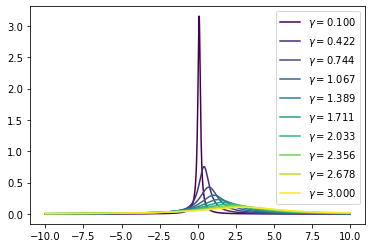

In [57]:
gamma = tnp.linspace(0.1, 3, 10)
dist = tfp.distributions.Cauchy(gamma, gamma)
x = tnp.linspace(-10, 10, 1000, dtype=tnp.float64)

fig, ax = plt.subplots()
ax.set_prop_cycle(cycler(color=plt.cm.viridis(tnp.linspace(0, 1, gamma.size))))
ax.plot(x, dist.prob(tnp.tile(x, (gamma.size, 1)).T))
ax.legend(list(f'$\\gamma=%.3f$' % i.numpy() for i in tnp.linspace(0.1, 3, 10)))

In [46]:
for i in tnp.linspace(0.1, 3, 10):
    print(type(i.numpy()))


<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


In [2]:
tau = GenParticle('tau', 1776.86).set_children(GenParticle('ν_τ', 1e-9), 
                                               GenParticle('e-', 522e-3),
                                               GenParticle('νₑ', 1e-9)
                                              )
tau2 = GenParticle('tau', 1776.86).set_children(GenParticle('ν_τ', 1e-9), 
                                                GenParticle('μ-', 105.658),
                                                GenParticle('ν_μ', 1e-9)
                                               )

In [3]:
weights, events = tau.generate(1000)
# TODO: What are weights?

In [11]:
def pT(fourvector: tf.Tensor) -> tf.Tensor:
    return tf.sqrt(fourvector[:, 0, ...]**2 + fourvector[:, 1, ...]**2)


# Test code

Import

In [1]:
import phasespace
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Constants

In [2]:
B0_MASS = 5279.58
PION_MASS = 139.57018
KAON_MASS = 493.677
K1_MASS = 1272.0
K1_WIDTH = 90.0
KSTARZ_MASS = 895.81
KSTARZ_WIDTH = 47.4

Functions

In [3]:
def make_norm_histo(array, range_, weights=None):
    """Make histo and modify dimensions."""
    histo = np.histogram(array, 100, range=range_, weights=weights)[0]
    return histo / np.sum(histo)

Main code

In [4]:
n_particles = 2
first_run_n_events = 100
main_run_n_events = 1000
n_events = tf.Variable(initial_value=first_run_n_events, dtype=tf.int64)

decay = phasespace.nbody_decay(B0_MASS, [PION_MASS] * n_particles)

In [5]:
generate = decay.generate(n_events)
weights1, _ = generate  # only generate to test change in n_events

# change n_events and run again
n_events.assign(main_run_n_events)
weights, particles = decay.generate(n_events)
parts = np.concatenate(
    [particles[f"p_{part_num}"] for part_num in range(n_particles)], axis=1
)
histos = [
    make_norm_histo(
        parts[:, coord],
        range_=(-3000 if coord % 4 != 3 else 0, 3000),
        weights=weights,
    )
    for coord in range(parts.shape[1])
]
weight_histos = make_norm_histo(weights, range_=(0, 1 + 1e-8))

# Let's plot
x = np.linspace(-3000, 3000, 100)
e = np.linspace(0, 3000, 100)

fig, axes = plt.subplots(nrows=1, ncols=len(histos)+1, figsize=(20, 3), constrained_layout=True)
for ax, coord in zip(axes, range(len(histos))):
    ax.hist(
        x if coord % 4 != 3 else e,
        weights=histos[coord],
        alpha=0.5,
        label="phasespace",
        bins=100,
    )
    # ax.savefig(
    #     os.path.join(
    #         PLOT_DIR,
    #         "{}_pion_{}_{}.png".format(
    #             test_prefix, int(coord / 4) + 1, ["px", "py", "pz", "e"][coord % 4]
    #         ),
    #     )
    # )
axes[0].legend(loc="upper right")
    
axes[-1].hist(
    np.linspace(0, 1, 100),
    weights=weight_histos,
    alpha=0.5,
    label="phasespace",
    bins=100,
);
# plt.savefig(os.path.join(PLOT_DIR, f"{test_prefix}_weights.png"))

NotImplementedError: Cannot convert a symbolic Tensor (ReadVariableOp:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported